In [7]:
!pip install git+https://github.com/jsh9/python-plot-utilities

  Cloning https://github.com/jsh9/python-plot-utilities to c:\users\01joja\appdata\local\temp\pip-req-build-t2cv7uca
  Created wheel for plot-utils: filename=plot_utils-0.6.6-py3-none-any.whl size=13278151 sha256=a62c02ac3a5b642d559b715896d8910e82d1912df59c41232f74f4213fff2618
  Stored in directory: C:\Users\01joja\AppData\Local\Temp\pip-ephem-wheel-cache-zsejomal\wheels\d0\99\78\05b2d3be85d4e5d1f5fec6dcb8ac2b5866bbed0a86fd1756b0
Successfully built plot-utils


Running command git clone -q https://github.com/jsh9/python-plot-utilities 'C:\Users\01joja\AppData\Local\Temp\pip-req-build-t2cv7uca'


In [8]:
from brian2 import *
import sympy
import plot_utils

In [30]:
# Functions that are used in the notebook
from random import random, randrange

# Fetched from the brian2 totoruial
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1) 
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

# Generates data that we can test the network on.
def spikegen(N: int, end_time: int, star_time: int =  0, random_start: bool = False):
  delta_time = (end_time - star_time)
  # Initialize a direction list
  labels = [None] * delta_time
  spikes = [None] * delta_time
  times = [None] * delta_time

  if random_start:
    start_place = randrange(0, N)
  else:
    start_place = round(N/2)

  # Set first spike manually
  labels[0] = 0
  spikes[0] = start_place
  times[0] = 0
  
  t = 1
  id = start_place
  cooldown = 0
  target = id
  dir = 0

  while t < delta_time:
    # Get a target
    if id == target:
      while id == target:
        target = randrange(0, N)
      dir = round((target - id) / abs(target - id))
      #print(dir)

    # Check whether to move to stand still
    still = True
    if cooldown == 0:
      # 10% chance of standing still
      if randrange(0, 20) == 0:
        cooldown = 3
      else:
        still = False
    else:
      cooldown -= 1

    d = 0 if still == True else dir
    # Do movement
    id += d

    # Set output data
    labels[t] = d
    spikes[t] = id
    times[t] = t

    #print('t: {:1d}\tid: {:1d}\td: {:1d}\ttarget: {:1d}'.format(t, id, d, target), end='\n')
    t += 1

  return {
    'labels': labels,
    'spikes': spikes,
    'times': times
  }


def filter_spikes(data):
  ## Removes zeros so it dose not spike on them.
  z = list(zip(*[data[k] for k in data]))
  f = [r for r in z if r[0] != 0]
  v = [list(t) for t in zip(*f)]

  o = dict()
  for i, k in enumerate(data):
    o[k] = v[i]
  return o



def network_guess(left_spikes,right_spikes):
    ## Will return a list that display the movments
    left_i = 0
    left_last = len(left_spikes)
    right_i = 0
    right_last = len(right_spikes)
    total_lenght = left_last + right_last
    movments = []
    movments_i = 0
    
    while left_i + right_i < total_lenght:
        if left_spikes[left_i] == right_spikes[right_i]:
            right_i +=1
            left_i +=1
            movments.append(0)
        elif left_spikes[left_i] > right_spikes[right_i]:
            movments.append(1)
            right_i +=1
        else:
            movments.append(-1)
            left_i +=1
        if left_i == left_last:
            while right_i < right_last:
                movments.append(1)
                right_i +=1
        if right_i == right_last:
            while left_i < left_last:
                movments.append(-1)
                left_i +=1
    return movments

## Generate movment data

In [31]:
input_neurons = 100 ### insert no of input neurons here ###
time = 180

data = spikegen(input_neurons, time)
data_without_zeros = filter_spikes(data)

## Creates the network

In [32]:
#https://brian2.readthedocs.io/en/stable/examples/frompapers.Stimberg_et_al_2018.example_1_COBA.html
start_scope()

seed(11922)  # to get identical figures for repeated runs


################################################################################
# Model parameters
################################################################################
### General parameters

labels = data_without_zeros['labels']
spikes = data_without_zeros['spikes']
time_for_spikes = data_without_zeros['times']*ms

duration = time*ms    # Total simulation time
sim_dt = 0.01*ms        # Integrator/sampling step


### Neuron parameters
tau_m = 30*ms         # Excitatory synaptic time constant
V_th = 50e-3         # Firing threshold
V_r = 35e-3          # Reset potential       
R = 90e6




### Synapse parameters
we = 1          # Excitatory synaptic weight
wi = -1           # Inhibitory synaptic weight

#indices = [3,4,5,6,5,4,3,3,4,5,6,5,4,3] #np.linspace(0, 50, num=2)
#times = [10,11,12,13,14,15,16,30,31,32,33,34,35,36]*ms #np.linspace(10, 90, num=2)*ms




################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### Neurons
neuron_eqs = '''
dv/dt = ((V_r-v)+R*I)/tau_m : 1
I : 1
'''
input_group = NeuronGroup(input_neurons, model=neuron_eqs,threshold='v>V_th', reset='v=V_r', method='euler')

neurons = NeuronGroup(3*input_neurons-2, model=neuron_eqs,threshold='v>V_th', reset='v=V_r', method='euler')

left = NeuronGroup(1, model=neuron_eqs,threshold='v>V_th',reset='v=V_r', method='euler')

right = NeuronGroup(1, model=neuron_eqs,threshold='v>V_th',reset='v=V_r', method='euler')

neurons.I  = 50e-12
neurons.v = input_group.v = left.v = right.v = 'V_r'

input_layer = SpikeGeneratorGroup(input_neurons, spikes, time_for_spikes, dt=sim_dt) # assigs 1/4 of the neurons to the input layer
#input_layer = input_group[:input_neurons]
inh_neurons = neurons[:input_neurons] # assigs 1/4 of the neurons to the inhibitory layer
left_layer  = neurons[1*input_neurons:2*input_neurons-1] # assigs 1/4 -1 of the neurons to the left exitatory layer
right_layer = neurons[2*input_neurons-1:3*input_neurons-2] # assigs 1/4 -1 of the neurons to the right exitatory layer
left_neuron = left[0] # assigns 1 of the neurons to the final left layer
right_neuron= right[0] # assigns 1 of the neurons to the final right layer

### Synapses
exc_syn = Synapses(input_layer, inh_neurons, model = 'w : 1', on_pre = 'v += w') # Connects the input layer to the inhibitory layer
exc_syn_left = Synapses(input_layer, left_layer, model = 'w : 1', on_pre = 'v += w') # Connects the input layer to the left exitatory layer
exc_syn_right = Synapses(input_layer, right_layer, model = 'w :1', on_pre = 'v += w') # Connects the input layer to the right exitatory layer
inh_syn_right = Synapses(inh_neurons, right_layer, model = 'w : 1', on_pre = 'v += w') # Connects the inhibitory layer to the right exitatory layer
inh_syn_left = Synapses(inh_neurons, left_layer, model = 'w : 1', on_pre = 'v += w') # Connects the inhibitory layer to the left exitatory layer
final_left = Synapses(left_layer, left_neuron, model = 'w : 1', on_pre = 'v += w') # Connects the left exitatory layer to the final left neuron
final_right = Synapses(right_layer, right_neuron, model = 'w : 1', on_pre = 'v += w') # Connects the right exitatory layer to the final right neuron

exc_syn.connect(i=[*range(0,input_neurons)],j=[*range(0,input_neurons)])
exc_syn_left.connect(i=[*range(1,input_neurons)],j=[*range(0,input_neurons-1)])
exc_syn_right.connect(i=[*range(0,input_neurons-1)],j=[*range(0,input_neurons-1)])
inh_syn_right.connect(i=[*range(1,input_neurons)],j=[*range(0,input_neurons-1)])
inh_syn_left.connect(i=[*range(0,input_neurons-1)],j=[*range(0,input_neurons-1)])
final_left.connect(i=[*range(0,input_neurons-1)],j=0)
final_right.connect(i=[*range(0,input_neurons-1)],j=0)

exc_syn.w = 60e-3
exc_syn_left.w = 60e-3
exc_syn_right.w = 60e-3
inh_syn_right.w = -100e-3
inh_syn_left.w = -100e-3
final_left.w = 60e-3
final_right.w = 60e-3


#visualise_connectivity(exc_syn)
#visualise_connectivity(exc_syn_left)
#visualise_connectivity(exc_syn_right)
#visualise_connectivity(inh_syn_left)
#visualise_connectivity(inh_syn_right)
#visualise_connectivity(final_left)
#visualise_connectivity(final_right)


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
#exc_mon = SpikeMonitor(input_layer)
#inh_mon = SpikeMonitor(inh_neurons)

### We record some additional data from a single excitatory neuron

left_monitor = StateMonitor(left_neuron, 'v', record=0)
left_event = EventMonitor(left, event='spike', variables='v')
right_monitor = StateMonitor(right_neuron, 'v', record=0)
right_event = EventMonitor(right, event='spike', variables='v')
#L_right = StateMonitor(inh_neurons, 'v', record=0)

print('Halfway there')





Halfway there


## Run the network

In [33]:
run(duration, report='text')

Starting simulation at t=0. s for a duration of 180. ms
180. ms (100%) simulated in 2s


## Evaluate the result

1.02 ms
[False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
[  1.02   2.02   3.02   4.02   5.02   6.02   7.02   8.02   9.02  10.02
  11.02  12.02  17.02  18.02  19.02  20.02  21.02  22.02  23.02  24.02
  25.02  26.02  27.02  28.02  3

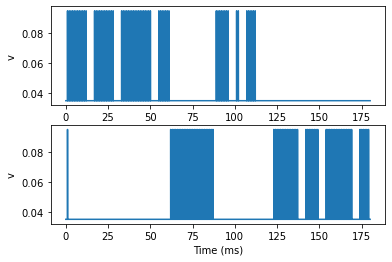

In [34]:
import copy

figure()
subplot(211)
plot(left_monitor.t/ms, left_monitor.v[0])
xlabel('Time (ms)')
ylabel('v');
subplot(212)
plot(right_monitor.t/ms, right_monitor.v[0])
xlabel('Time (ms)')
ylabel('v');

print(left_event.it[1].__getitem__(0))
left_array = left_event.it[1].__array__()
right_array = right_event.it[1].__array__()
result = network_guess(left_array,right_array)

final_result = copy.deepcopy(result)
for i in range(0, len(result)):
    final_result[i] = (result[i] == labels[i])

print(final_result)

print(left_array)
print(right_array)

